# 1. As características de um problema não-supervisionado

O modelo nao-supervisionado funciona se baseando em convergir a partir da similaridade de atributos entre entidades diferentes. Por exemplo, a partir de frutas com atributos semelhantes (tamanho, cor, formato, etc) o não-supervisionado agrupa. Um dos maiores desafios deste tipo de modelo é que não existe resposta errada, todo algoritmo de clusterização retornará um cluster. Outro desafio é que toda a fundamentação de machine learning se baseia no erro e, por isso, a performance dos modelos são medidos mais na prática. 

Outro ponto importante é que, em geral, clusterização é o meio e não o fim. A ideia é sumarizar os dados por algum motivo. Por exemplo, no caso aqui são os "Insiders", que é um grupo reduzido a partir de um grande grupo. 

# PA 005 - High Value Customer Identification (Insiders)

## 0.0. Planejamento da Solução (IoT)

### 0.1. Input (Entrada)

1. Problema de Negócio
    - Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
    
2. Conjunto de dados
    - Vendas de um e-commerce online durante um periodo de um ano.

### 0.2. Output (Saída)

1. A indicação das pessoas que farão parte do programa de Insiders
    - Lista: client_id | is_insider


2. Relatório com as respostas das perguntas de negócio
    - Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - Quantos clientes farão parte do grupo?
    - Quais as principais características desses clientes ?
    - Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Quais as condições para uma pessoa ser removida do Insiders ?
    - Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Quais ações o time de marketing pode realizar para aumentar o faturamento?

### 0.3 Tasks (Tarefas)

1. Quem são as pessoas elegíveis para participar do programa de Insiders ?
    - O que é ser elegível? O que são clientes de maior "valor"?
        - Faturamento
            - Alto ticket médio
            - Alto LTV (Life Time Value)
            - Baixa Recência (baixo tempo entre duas compras)
            - Alto Basket Size (tamanho da cesta de compras)
            - Baixa probabilidade de churn (churn é quando a empresa para de utilizar seu serviço)
            - Alta propensão de compra
            
        - Custo
            - Baixa taxa de devolução
            
        - Experiência de Compra
            - Média alta das avaliações
            
            
2. Quantos clientes farão parte do grupo?
    - Número total de clientes
        - % do grupo Insiders
    
    
3. Quais as principais características desses clientes ?
    - Escrever características dos clientes
        - Idade
        - Localização 
    
    - Características do consumo
        - Features da clusterização


4. Qual a porcentagem de contribuição do faturamento, vinda do Insiders ?
    - Faturamento total do ano
    - Faturamento do grupo insiders


5. Qual a expectativa de faturamento desse grupo para os próximos meses ?
    - LTV do grupo Insiders
    - Séries temporais (ARIMA, ARMA, HoltWinter, etc)
    

6. Quais as condições para uma pessoa ser elegível ao Insiders ?
    - Definir a periodicidade (1 mês, 3 meses, etc)
    - A pessoa precisa ser similar ou parecido com uma pessoa do grupo


7. Quais as condições para uma pessoa ser removida do Insiders ?
    - Definir a periodicidade (1 mês, 3 meses, etc)
    - A pessoa precisa ser disimilar ou não-parecido com uma pessoa do grupo


8. Qual a garantia que o programa Insiders é melhor que o restante da base ?
    - Teste A/B
    - Teste A/B Bayesiano
    - Teste de Hipóteses


9. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    - Desconto
    - Preferência de Compra
    - Frete Grátis
    - Visita a empresa


# 0.0 Imports

In [138]:
import pandas  as pd
import numpy   as np
import seaborn as sns

from matplotlib      import pyplot as plt
from IPython.display import HTML
from sklearn import cluster as c
from sklearn import metrics as m
from plotly import express as px
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import umap.umap_ as umap

from pandas_profiling import ProfileReport

from sklearn import preprocessing as pp

from sklearn import decomposition as dd
from sklearn.manifold import TSNE
from sklearn import ensemble as en

## 0.1 Helper Functions

In [139]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width: 100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['indices']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Load Dataset

In [140]:
# read data
df_raw = pd.read_csv('../data/Ecommerce.csv', encoding='unicode_escape')

# drop exatra column
df_raw = df_raw.drop('Unnamed: 8', axis=1)

In [141]:
df_raw.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,17850.0,United Kingdom


# 1.0 Descrição dos dados

## 1.1 Rename Columns

In [142]:
df1 = df_raw.copy()

In [143]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [144]:
cols_new = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols_new

In [145]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
259940,559784,22386,JUMBO BAG PINK POLKADOT,100,10-Jul-17,1.79,16839.0,United Kingdom


## 1.2 Data Dimensions

In [146]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'. format(df1.shape[1]))

Number of rows: 541909
Number of columns: 8


## 1.3 Data Types

In [147]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check NA

In [148]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

O fato de ter 135k customer_id sem identificação é um problema, uma vez que o objetivo é construir clusters identificando os clientes. A princípio, serão removidos 135k de linhas, mas é importante entender o que houve e o motivo de estarem assim.

## 1.5 Replace NA

In [149]:
df_missing = df1.loc[df1['customer_id'].isna(),:]
df_not_missing = df1.loc[~df1['customer_id'].isna(),:]

In [150]:
# create reference - Adicionando um valor para customer_id que não tenha na base. Como o máx é 19000, o primeiro id missing que aparecer será o 19001 e assim por diante.
df_backup = pd.DataFrame(df_missing['invoice_no'].drop_duplicates())
df_backup['customer_id'] = np.arange(19000, 19000+len(df_backup),1)

# merge original with reference dataframe
df1 = pd.merge(df1, df_backup, on='invoice_no', how='left')

# coalesce
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'])

In [151]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Dtypes

In [152]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [153]:
# invoice_date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer_id
df1['customer_id'] = df1['customer_id'].astype('int64')

In [154]:
df1.sample()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
498694,578533,23102,SILVER HEARTS TABLE DECORATION,6,2017-11-22,0.83,United Kingdom,17767


In [155]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [156]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [157]:
d = num_attributes.describe()
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenate
df_num = pd.concat([d,d1,d2]).T.reset_index()
df_num.columns = ['attributes', 'count', 'mean', 'std','min','25%','50%', '75%', 'max', 'skew', 'kurtosis']
df_num

,attributes,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
0,quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0,-0.264076,119769.160031
1,unit_price,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0,186.506972,59005.719097
2,customer_id,541909.0,16688.840453,2911.411352,12346.00,14367.00,16249.00,18283.00,22709.0,0.487449,-0.804287


#### 1.7.1.1 Numerical Attributes - Investigating

1. Quantity negativa (pode ser devolução)
2. Preço unitário igual a zero (pode ser promoção?)

### 1.7.2 Categorical Attributes

In [158]:
cat_attributes.head()

,invoice_no,stock_code,description,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,United Kingdom
1,536365,71053,WHITE METAL LANTERN,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,United Kingdom


In [159]:
# invoice number
print(f"Total de parâmetros com caracter diferente de número: {len(cat_attributes.loc[cat_attributes['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'invoice_no'].drop_duplicates() ) }")

df_letter_invoices = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]
print(f'Total de números negativos: {len(df_letter_invoices[df_letter_invoices["quantity"] > 0])}')

Total de parâmetros com caracter diferente de número: 3839
Total de números negativos: 3


Existe um total de 3654 invoice_no que estão com algum tipo de letra no nome, o que impede de fazer a conversão para número. Além disso, todos as quantidades estão negativas nesta situação, o que é estranho, uma vez que os valores de compras precisam ser positivos. Estes valores negativos podem ser considerados devoluções de produtos.

In [160]:
# stock_code
print(len(cat_attributes.loc[cat_attributes['stock_code'].apply(lambda x: bool(re.search('[^0-9]+', x))), 'stock_code'] ))

# total com todos os parametros sendo string
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

54873


array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

Existem variáveis que podem ser sujeiras, não indicam nada para gente. 

In [161]:
# description

# Delete description

In [162]:
# Country

# total de paises
print(f"Total de países: {(len(df1['country'].unique()))}")

#representatividade dos paises nas compras por pais
print("Lista dos Países: ")
df1['country'].value_counts(normalize=True)

Total de países: 38
Lista dos Países: 


United Kingdom          0.914320
Germany                 0.017521
France                  0.015790
EIRE                    0.015124
Spain                   0.004674
Netherlands             0.004375
Belgium                 0.003818
Switzerland             0.003694
Portugal                0.002803
Australia               0.002323
Norway                  0.002004
Italy                   0.001482
Channel Islands         0.001399
Finland                 0.001283
Cyprus                  0.001148
Sweden                  0.000853
Unspecified             0.000823
Austria                 0.000740
Denmark                 0.000718
Japan                   0.000661
Poland                  0.000629
Israel                  0.000548
USA                     0.000537
Hong Kong               0.000531
Singapore               0.000423
Iceland                 0.000336
Canada                  0.000279
Greece                  0.000269
Malta                   0.000234
United Arab Emirates    0.000125
European C

# 2.0 Data Filtering

In [163]:
df2 = df1.copy()

In [164]:
# unit price > 0.01
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# stock code != [POST, D, M, DOT, CRUK]
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# description
df2 = df2.drop(columns='description', axis=1)

# map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]

# bad users - Pessoas com comportamentos estranho na analise exploratória de dados
df2 = df2[~df2['customer_id'].isin([16446 ])]

## quantity - Negative number means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2_purchase = df2.loc[df2['quantity'] >= 0, :]

# 3.0 Feature Engineering

In [165]:
# Feature Ideas:
## Moving Average - 7d, 14d, 30d
## Quantidade de compras por mês, antes do dia 15 e depois do dia 15
## Average Financial

## 

In [166]:
df3 = df2.copy()

## 3.1 Feature Creation

In [167]:
df3.head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,6,2016-11-29,2.55,United Kingdom,17850
1,536365,71053,6,2016-11-29,3.39,United Kingdom,17850
2,536365,84406B,8,2016-11-29,2.75,United Kingdom,17850
3,536365,84029G,6,2016-11-29,3.39,United Kingdom,17850
4,536365,84029E,6,2016-11-29,3.39,United Kingdom,17850


Será criado uma tabela de referência, com a menor granularidade possível

In [168]:
df_ref = df3.drop(['invoice_no', 'stock_code', 
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis = 1).drop_duplicates(ignore_index=True)
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


### 3.1.1 Gross Revenue

In [169]:
# Gross Revenue (Faturamento) = quantity * price
df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:,'quantity']*df2_purchase.loc[:,'unit_price']

# Monetary (Quanto esta pessoa gastou na loja)
df_monetary = df2_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()

# Adicionando no datafram de referencia
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how='left')
df_ref.isna().sum()

C:\Users\t.mesha09\AppData\Local\Temp\ipykernel_68696\1121802770.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_purchase.loc[:, 'gross_revenue'] = df2_purchase.loc[:,'quantity']*df2_purchase.loc[:,'unit_price']


customer_id       0
gross_revenue    91
dtype: int64

### 3.1.2 Recency - Day from last purchase

In [170]:
# Recency - Last Day Purchase
# Como o dataset é antigo, será escolhido a data como a última data de compra do dataset. Esta data servirá de referencia, uma vez que o recorte dos dados é de dois anos atrás.
# em um projeto real, é selecionado o datetime.today(), selecionando assim a data de HOJE.
df_recency = df2_purchase[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df2_purchase['invoice_date'].max()-df_recency['invoice_date']).dt.days
df_recency = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
dtype: int64

### 3.1.3 Quantity of purchased

In [171]:
# Numero de produtos
df_frequency = df2_purchase[['customer_id', 'invoice_no']].groupby('customer_id').count().reset_index().rename(columns={'invoice_no': 'qtde_invoices'})
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
dtype: int64

### 3.1.4 Quantity of items purchased

In [172]:
# Numero de produtos
df_frequency = df2_purchase[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_itens'})
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
dtype: int64

### 3.1.5 Quantity of products purchased

In [173]:
  # Numero de produtos
df_frequency = df2_purchase[['customer_id', 'stock_code']].groupby('customer_id').count().reset_index().rename(columns={'stock_code ': 'qtde_produtos '})
df_ref = pd.merge(df_ref, df_frequency, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
stock_code       91
dtype: int64

### 3.1.5 Average Ticket Value

In [174]:
# Avg Ticket
df_avg_ticket = df2_purchase[['customer_id', 'gross_revenue']].groupby('customer_id').mean().reset_index().rename(columns={'gross_revenue': 'avg_ticket'})
df_avg_ticket['avg_ticket'] = np.round(df_avg_ticket['avg_ticket'],2)
df_ref = pd.merge(df_ref, df_avg_ticket, how='left', on='customer_id')
df_ref.isna().sum()

customer_id       0
gross_revenue    91
recency_days     91
qtde_invoices    91
qtde_itens       91
stock_code       91
avg_ticket       91
dtype: int64

### 3.1.6 Average Recency Days

In [175]:
# media entre as compras

In [176]:
# average recency days
df_aux = df2[['customer_id','invoice_date']].drop_duplicates().sort_values(['customer_id', 'invoice_date'], ascending=[True, True])
df_aux['next_customer_id'] = df_aux['customer_id'].shift() #next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoice date

df_aux['avg_recency_days'] = df_aux.apply(lambda x: (x['invoice_date'] - x['previous_date']).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1)

df_aux.drop(['invoice_date', 'next_customer_id', 'previous_date'], axis=1).dropna()

# average recency
df_avg_recency_days = df_aux.groupby('customer_id').mean().reset_index()

# merge
df_ref = pd.merge(df_ref, df_avg_recency_days, on='customer_id', how='left')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
stock_code            91
avg_ticket            91
next_customer_id       1
avg_recency_days    2816
dtype: int64

### 3.1.7 Frequency Purchase

In [177]:
df_aux = (df2_purchase[['customer_id', 'invoice_no', 'invoice_date']].drop_duplicates()
                                                            .groupby('customer_id')
                                                            .agg(max_  = ('invoice_date', 'max'), 
                                                                 min_  = ('invoice_date', 'min'), 
                                                                 days_ = ('invoice_date', lambda x: (x.max() - x.min()).days +1),
                                                                 buy_  = ('invoice_no', 'count') )  ).reset_index()

# frequency
df_aux['frequency'] = df_aux[['buy_', 'days_']].apply(lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'frequency']], on='customer_id', how='left') 
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
stock_code            91
avg_ticket            91
next_customer_id       1
avg_recency_days    2816
frequency             91
dtype: int64

### 3.1.8 Number of Returns

In [178]:
# number of returns
df_returns = df2_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index().rename(columns={'quantity': 'qtde_returns'})
df_returns['qtde_returns'] = df_returns['qtde_returns']*(-1)

df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref.loc[df_ref['qtde_returns'].isna(),'qtde_returns'] = 0

df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
stock_code            91
avg_ticket            91
next_customer_id       1
avg_recency_days    2816
frequency             91
qtde_returns           0
dtype: int64

### 3.1.9 Basket Size - Quantidade de itens por cesta (quantity)

In [179]:
# Em media, quantas pessoas compram quando vão ao mercado

In [180]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no','quantity']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('quantity','sum')) 
                                                                         .reset_index())
# calculation
df_aux['avg_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id            0
gross_revenue         91
recency_days          91
qtde_invoices         91
qtde_itens            91
stock_code            91
avg_ticket            91
next_customer_id       1
avg_recency_days    2816
frequency             91
qtde_returns           0
avg_basket_size       91
dtype: int64

### 3.1.10 Unique Basket Size = Quantidade de produtos distintos por compra

In [181]:
df_aux = (df2_purchase.loc[:, ['customer_id', 'invoice_no','stock_code']].groupby('customer_id')
                                                                         .agg(n_purchase=('invoice_no', 'nunique'),
                                                                              n_products=('stock_code','nunique')) 
                                                                         .reset_index())

# calculation
df_aux['avg_unique_basket_size'] = df_aux['n_products'] / df_aux['n_purchase']

# merge
df_ref = pd.merge(df_ref, df_aux[['customer_id', 'avg_unique_basket_size']], how='left', on='customer_id')
df_ref.isna().sum()

customer_id                  0
gross_revenue               91
recency_days                91
qtde_invoices               91
qtde_itens                  91
stock_code                  91
avg_ticket                  91
next_customer_id             1
avg_recency_days          2816
frequency                   91
qtde_returns                 0
avg_basket_size             91
avg_unique_basket_size      91
dtype: int64

In [182]:
df_ref.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,297.0,1733.0,297.0,18.15,17849.666667,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,171.0,1390.0,171.0,18.90,13046.923077,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,232.0,5028.0,232.0,28.90,12582.941176,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,28.0,439.0,28.0,33.87,13747.750000,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,15099.833333,8.600000,0.073171,22.0,26.666667,0.333333


# 4.0 EDA - Exploratory Data Analysis

In [183]:
df4 = df_ref.dropna().copy()

In [184]:
df4.isna().sum()

customer_id               0
gross_revenue             0
recency_days              0
qtde_invoices             0
qtde_itens                0
stock_code                0
avg_ticket                0
next_customer_id          0
avg_recency_days          0
frequency                 0
qtde_returns              0
avg_basket_size           0
avg_unique_basket_size    0
dtype: int64

## 4.1 Univariate Analysis

**Notes**
Em modelos de clusterização, as ideias principais são:

    1. Encontrar clusters coesos e separado
    2. Entender métricas como: 
        - Mínimo, Máximo, Range (dispersão)
        - Média e Mediana 
        - Desvio Padrão e Variância
        - Coeficiente de Variação (desvio padrão dividido pela média)
        - Distribuição

In [185]:
profile = ProfileReport(df4)
profile.to_file('output_V2.html')

Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.97it/s]


**Analisando outliers**

### 4.1.1 Gross Revenue

In [186]:
df4.sort_values('gross_revenue', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,2060.0,196844.0,2060.0,135.50,14645.978261,7.844444,0.203390,288.0,2733.944444,9.708333
492,18102,259657.30,0.0,431.0,64124.0,431.0,602.45,18101.961538,14.680000,0.163043,0.0,1068.733333,2.500000
433,17450,194550.79,8.0,337.0,69993.0,337.0,577.30,17449.965517,12.821429,0.127778,952.0,1521.586957,2.695652
66,14911,140450.72,1.0,5673.0,80263.0,5673.0,24.76,14910.993056,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,713.0,77373.0,713.0,174.70,12414.937500,20.866667,0.063694,427.0,3868.650000,22.150000


In [187]:
df4[df4['customer_id'] == 14646].head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,2060.0,196844.0,2060.0,135.5,14645.978261,7.844444,0.20339,288.0,2733.944444,9.708333


Apesar de um gross revenue muito alto, nada indica aqui que há um erro com este cliente, apenas um outlier que pode ser interessante para o cluster insider.

### 4.1.2 Qtde Itens

In [188]:
df4.sort_values('qtde_itens', ascending=False).head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
1017,14646,279138.02,1.0,2060.0,196844.0,2060.0,135.50,14645.978261,7.844444,0.203390,288.0,2733.944444,9.708333
66,14911,140450.72,1.0,5673.0,80263.0,5673.0,24.76,14910.993056,2.601399,0.533512,3332.0,403.331658,8.974874
1150,12415,124564.53,24.0,713.0,77373.0,713.0,174.70,12414.937500,20.866667,0.063694,427.0,3868.650000,22.150000
433,17450,194550.79,8.0,337.0,69993.0,337.0,577.30,17449.965517,12.821429,0.127778,952.0,1521.586957,2.695652
15,17511,91062.38,2.0,963.0,64549.0,963.0,94.56,17510.969697,11.593750,0.083333,1535.0,2082.225806,14.612903


Apesar de um valor muito alto, o cliente é o mesmo do gross revenue e não há nada de estranho, pode ser um usuário que compre muito (o dobro o segundo)

### 4.1.3 Avg Ticket

In [189]:
df4[df4['avg_ticket'] == 56157.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


Um ponto a ser analisado é que o cliente comprou 80997 itens, porém, devolveu 80995. É necessário entender melhor o que houve, para isso, será observado as principais compras.

In [190]:
df3[df3['customer_id'] == 16446]

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id


Nesta situação, o cliente no dia 2017-05-16 fez duas compras, uma no valor de 1.65 e outra no valor de 1.25. Algum tempo depois ele comprou 80995 itens e no mesmo dia devolveu esta quantidade. É importante pontuar com o time de negócio para entender se é importante manter alguém com tanta devolução no dataset ou se é necessário apenas excluí-lo. 

### 4.1.4 Frequency

In [191]:
df4[df4['frequency'] == 17]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,297.0,1733.0,297.0,18.15,17849.666667,35.5,17.0,40.0,50.970588,0.617647


In [192]:
df3[df3['customer_id'] == 17850].sort_values('quantity', ascending=False).head()

,invoice_no,stock_code,quantity,invoice_date,unit_price,country,customer_id
4528,536790,84406B,12,2016-11-30,2.75,United Kingdom,17850
4162,536750,71053,12,2016-11-30,3.39,United Kingdom,17850
3808,536685,85123A,12,2016-11-30,2.55,United Kingdom,17850
4526,536790,85123A,12,2016-11-30,2.95,United Kingdom,17850
4527,536790,71053,12,2016-11-30,3.39,United Kingdom,17850


Apesar de uma frequência alta se comparado com outros valores, nenhum comportamento estranho é encontrado aqui.

### 4.1.5 Avg Basket Size

In [193]:
df4[df4['avg_basket_size'] == 40498.5]

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size


É o mesmo outlier anterior, será retirado do dataset.

## 4.2 Bivariate Analysis

In [194]:
cols = ['customer_id']
df42 = df4.drop(cols, axis=1)

<Figure size 1800x864 with 0 Axes>

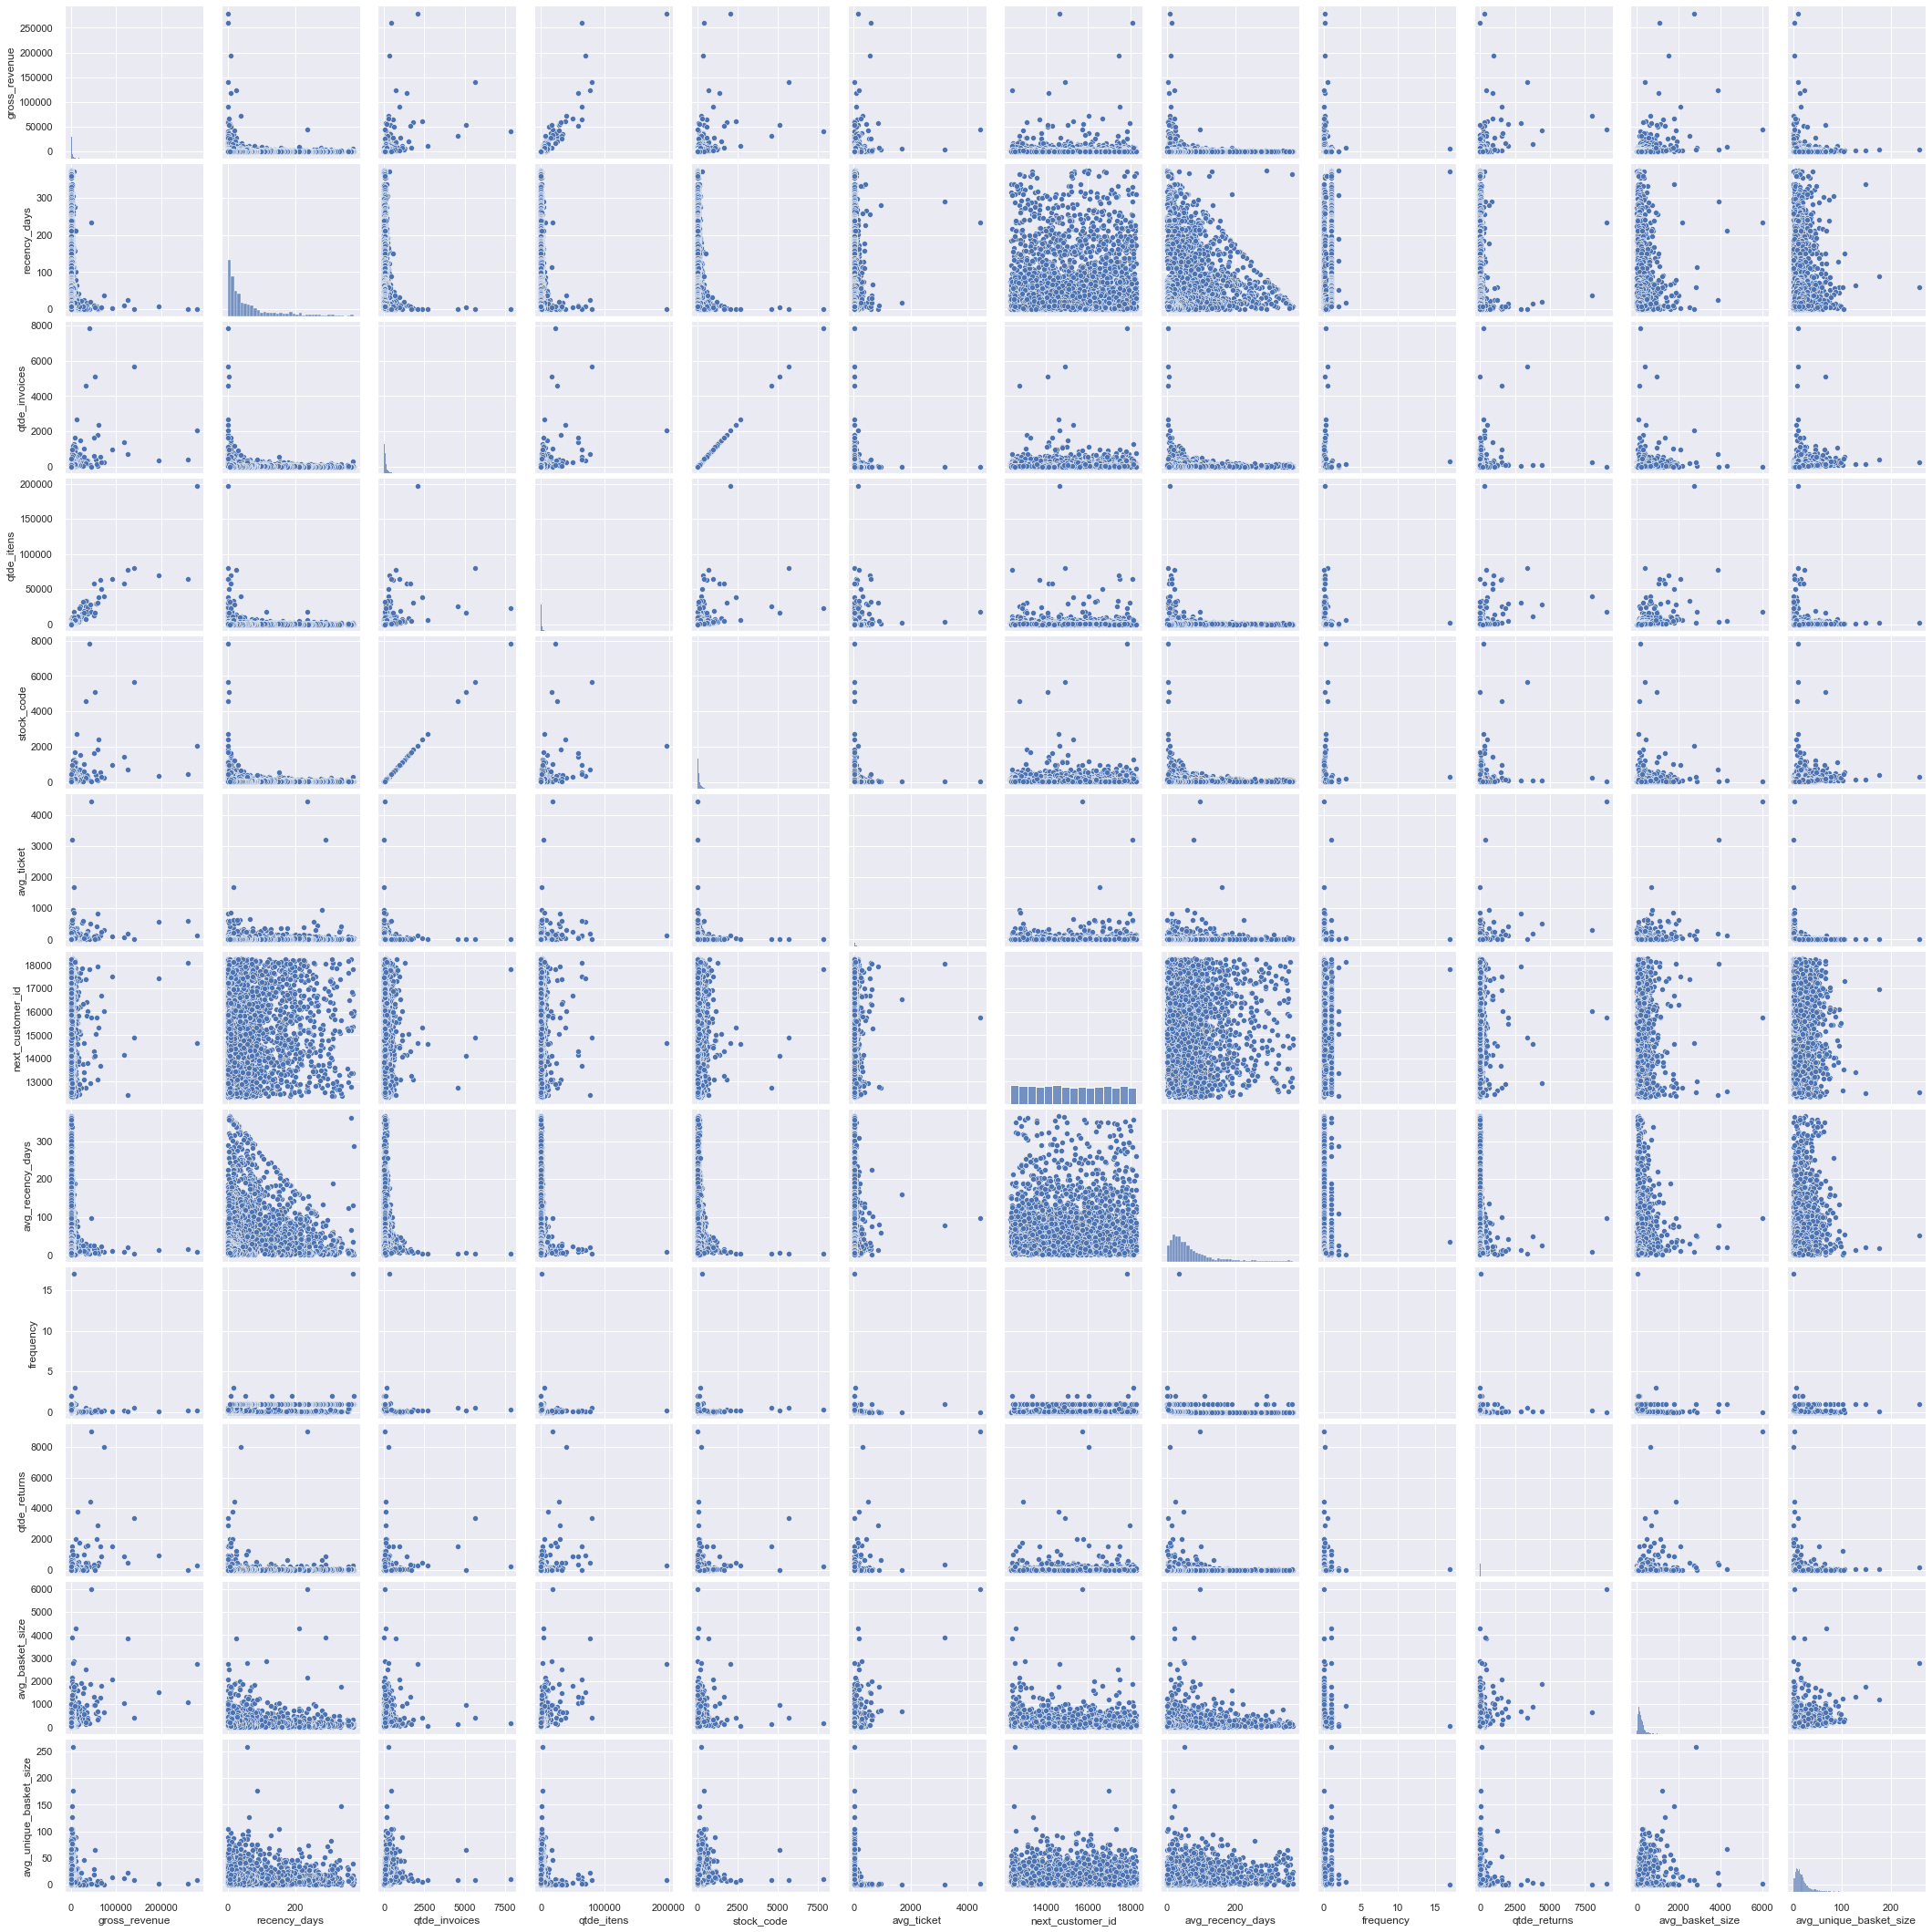

In [195]:
plt.figure(figsize=(25,12))
sns.pairplot(df42)

Observando a frequencia, é possível observar que não há uma variabilidade ao fazer o gráfico dela em relação as outras features. Este é um indício de uma variável irrelevante para os modelos de clusterização. 
Avg Ticket também segue a mesma ideia de pouca variação.

## 4.3 Estudo de Espaço de Features

O espaço de features é formado pelos registros (linhas) e as features (colunas). Este espaço de feature monta alguns clusters que podem estar misturados. Por exemplo, Frequência x Recência, a ideia da clusterização é que se tenha pontos coesos e distantes de outro cluster. Para fazer esta separação, é possível utilizar um espaço de embedding (ou espaço de latente).

O espaço de embedding é um espaço desconhecido e quando os pontos são transportados para este novo espaço os pontos são organização. Existe duas formas de construir este espaço novo, a primeira é utilizando algebra linear e a segunda utilizando algoritmos de machine learning. Um destes algoritmos é o PCA, ela torna as features novas como combinações lineares de outras features. Outra forma é utilizando decision trees. Quando a árvore constrói a separação, as folhas das arvores são os espaços de embbeding. Além dessas, tem o UMEP e o t-SNE também criam espaços de embedding. 

In [196]:
df43 = df4.drop(columns=['customer_id', 'next_customer_id'], axis=1).copy()

In [197]:
mm = pp.MinMaxScaler()

df43['gross_revenue']          = mm.fit_transform(df43[['gross_revenue']])
df43['recency_days']           = mm.fit_transform(df43[['recency_days']])
df43['qtde_invoices']          = mm.fit_transform(df43[['qtde_invoices']])
df43['qtde_itens']             = mm.fit_transform(df43[['qtde_itens']])
df43['stock_code']             = mm.fit_transform(df43[['stock_code']])
df43['avg_ticket']             = mm.fit_transform(df43[['avg_ticket']])
df43['avg_recency_days']       = mm.fit_transform(df43[['avg_recency_days']])
df43['frequency']              = mm.fit_transform(df43[['frequency']])
df43['qtde_returns']           = mm.fit_transform(df43[['qtde_returns']])
df43['avg_basket_size']        = mm.fit_transform(df43[['avg_basket_size']])
df43['avg_unique_basket_size'] = mm.fit_transform(df43[['avg_unique_basket_size']])

X = df43.copy()

In [198]:
df43.head()

,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.037770,0.008799,0.037770,0.003594,0.094521,1.000000,0.004438,0.008317,0.001614
1,0.011559,0.150134,0.021692,0.007056,0.021692,0.003763,0.071918,0.001345,0.003883,0.025539,0.044307
2,0.024000,0.005362,0.029476,0.025538,0.029476,0.006010,0.060788,0.002052,0.005547,0.055623,0.028594
3,0.003375,0.254692,0.003445,0.002225,0.003445,0.007126,0.251142,0.000734,0.000000,0.014447,0.017774
4,0.003116,0.892761,0.000255,0.000401,0.000255,0.065116,0.020822,0.003985,0.002441,0.004272,0.000515


### 4.3.1 PCA

In [199]:
X.shape[1]

11

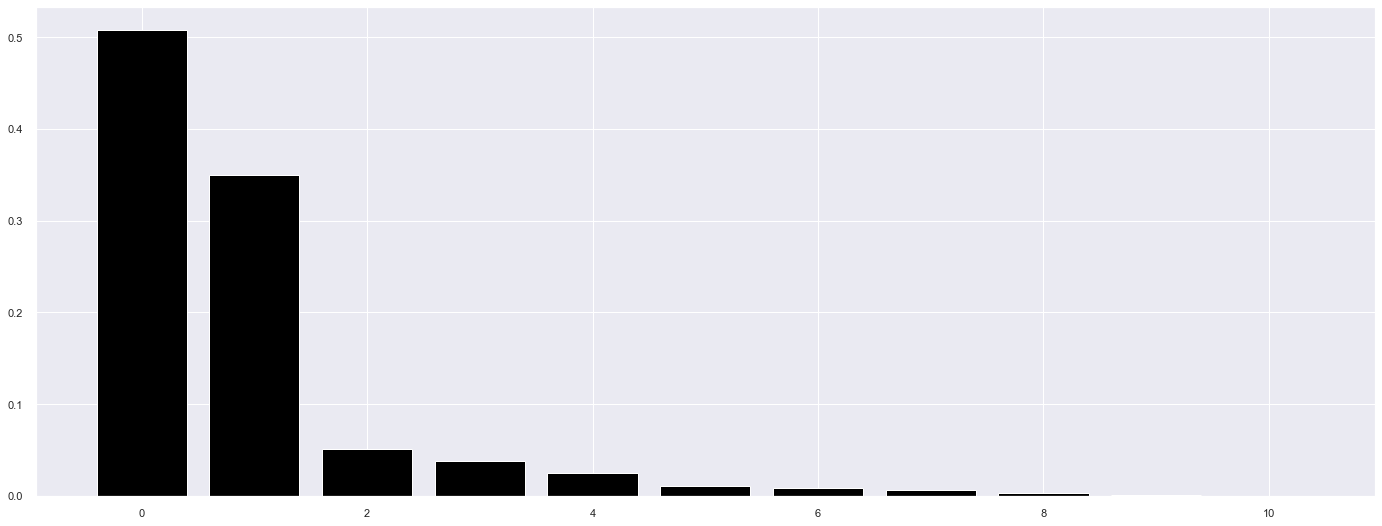

In [200]:
pca = dd.PCA(n_components=X.shape[1])

principal_components = pca.fit_transform(X)

# plot explained variable
features = range(pca.n_components_)

plt.bar(features, pca.explained_variance_ratio_, color='black')

#pca component
df_pca = pd.DataFrame(principal_components)

O gráfico indica quais são os principais componentes com maior variação de dados. 

<AxesSubplot:xlabel='0', ylabel='1'>

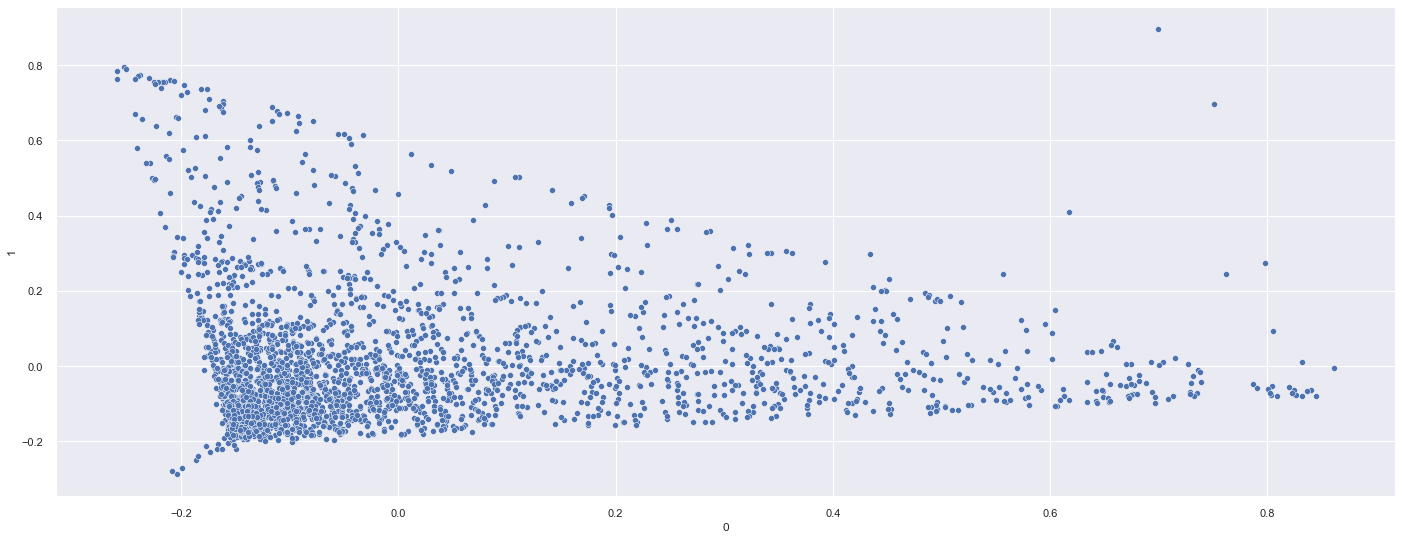

In [201]:
sns.scatterplot(x=0, y=1, data=df_pca)

Ou seja, não é possível ver nenhuma divisão nos dados a partir do PCA. 

### 4.3.2 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

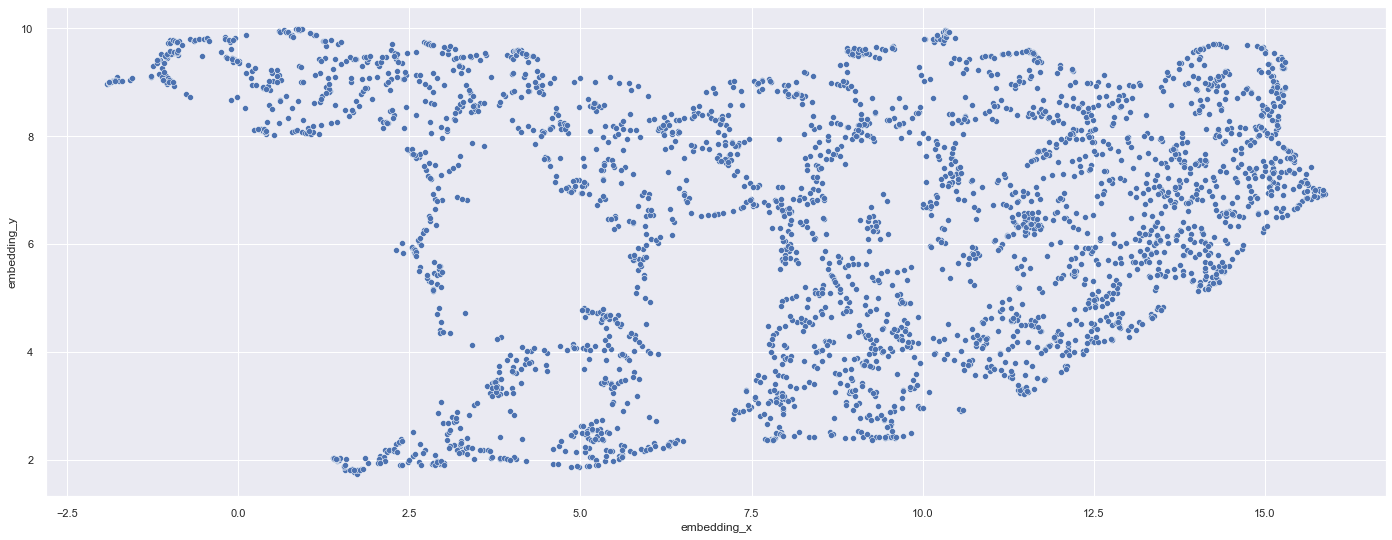

In [202]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',  
                data=df_pca)

Também não há uma grande separação dos dados a partir do UMAP.

### 4.3.3 t-SNE

C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

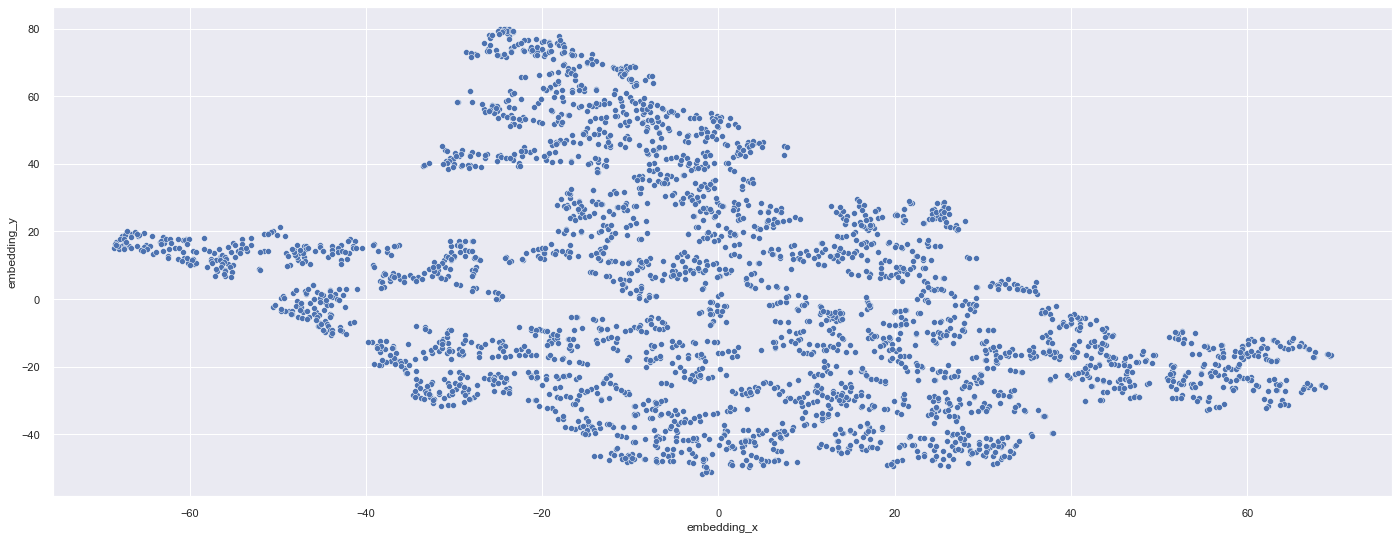

In [203]:
reducer = TSNE(n_components=2, random_state=42, n_jobs=-1)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',  
                data=df_pca)

### 4.3.3 Tree-Based Embedding

In [204]:
X.head()

,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.019292,0.997319,0.037770,0.008799,0.037770,0.003594,0.094521,1.000000,0.004438,0.008317,0.001614
1,0.011559,0.150134,0.021692,0.007056,0.021692,0.003763,0.071918,0.001345,0.003883,0.025539,0.044307
2,0.024000,0.005362,0.029476,0.025538,0.029476,0.006010,0.060788,0.002052,0.005547,0.055623,0.028594
3,0.003375,0.254692,0.003445,0.002225,0.003445,0.007126,0.251142,0.000734,0.000000,0.014447,0.017774
4,0.003116,0.892761,0.000255,0.000401,0.000255,0.065116,0.020822,0.003985,0.002441,0.004272,0.000515


Aqui vai ser definido que a variável gross_revenue é a variável "resposta", uma vez que está se tratando de um modelo não supervisionado e não existe variável resposta. A escolha desta variável se dá porque no final das contas o cluster Insider tem como principal característica pessoas que compram mais, assim, usar a gross_revenue faz sentido do ponto de vista de negócio.

In [205]:
# training dataset
X = df4.drop(columns = ['customer_id', 'next_customer_id', 'gross_revenue'])
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(random_state=42, n_estimators=100)

# model training
rf_model.fit(X, y)

# leaf

#dataframe leaf

RandomForestRegressor(random_state=42)

In [206]:
df_leaf = pd.DataFrame(rf_model.apply(X))

In [207]:
df_leaf.shape

(2968, 100)

In [208]:
df_leaf.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,2991,3177,3389,3357,2284,3162,2947,3099,2813,3005,2802,2951,2836,2897,2800,2781,2527,2997,3104,3163,3065,3078,2905,3024,3287,2987,3266,2862,2616,3041,3025,3040,3160,2978,2959,3248,3006,3123,2693,3029,3058,2809,3221,3134,3000,2837,2970,3136,3069,3046,2816,2737,2997,3401,3036,3043,2832,3042,2925,2977,3030,2888,2973,2927,3017,3045,3098,3135,2920,3123,3019,2990,2704,2967,3068,3162,2965,3104,2882,2945,3196,3159,3137,2886,3290,2628,2995,2855,3132,2978,2986,3070,3017,2696,3042,3045,3186,2832,3008,2914
1,2966,2955,3042,2968,2738,3148,2921,2830,2783,2937,2748,2566,2550,2909,2749,2778,3022,2956,3066,2415,2954,3019,2733,2834,3013,2915,2905,2781,2735,3030,2469,3020,2968,2746,2919,2970,2979,2667,2776,3019,2974,2786,3195,3109,2979,2770,2913,2908,2424,3020,2847,2818,2631,2951,2983,2961,3124,3017,2716,2903,2994,2867,2949,2865,2999,3032,2978,2396,2613,2945,2969,2968,3149,2926,2962,2786,2931,3070,2843,2536,2918,2781,2984,2585,2909,3155,2963,2821,3093,2880,2516,2620,2882,2928,3146,3025,2555,2799,2964,2866
2,3632,3609,3577,3411,3573,3658,3634,3548,3688,3641,3641,3578,3463,3652,3566,3567,3583,3657,3614,3463,3522,3638,3604,3523,3491,3647,3573,3603,3579,3717,3432,3673,3595,3634,3577,3616,3547,3560,3597,3475,3653,3398,3677,3443,3607,3600,3424,3651,3634,3553,3628,3503,3568,3611,3684,3653,3609,3645,3568,3570,3614,3589,3583,3689,3598,3624,3651,3441,3552,3624,3589,3427,3573,3605,3501,3481,3599,3567,3540,3471,3419,3444,3567,3428,3531,3627,3575,3696,3595,3566,3586,3518,3561,3565,3608,3461,3527,3617,3568,3624
3,1277,1412,1758,1361,1432,1461,1467,1475,1240,1340,1330,1439,1303,1518,1510,1367,1874,1371,1481,1388,1325,1443,1314,1495,1145,1455,1178,1481,1597,1304,1635,1533,1478,1452,1421,1578,1396,1491,1302,1572,1427,974,1461,1445,1300,1456,1232,1435,1394,1130,1316,1113,1350,1902,1399,1492,1329,1375,1298,1400,1478,1418,1505,1476,1579,1343,1097,1377,1066,1361,1707,1371,1320,1286,1272,1271,1407,1154,1385,1403,1249,1422,1519,1182,1482,1276,1375,1360,1699,1321,1467,1313,1342,1412,1230,1457,1467,1199,1879,1411
4,355,716,567,692,146,710,731,679,191,197,579,722,666,195,568,612,575,420,553,413,577,710,416,203,631,210,441,206,147,730,704,201,211,202,233,721,594,202,703,973,516,869,217,588,894,674,285,603,690,601,587,184,756,401,80,550,699,668,721,604,231,732,189,207,667,454,474,589,456,202,712,229,549,621,716,199,717,322,108,226,106,696,757,218,681,160,305,725,685,808,331,193,584,536,196,156,187,705,706,175
5,3231,3437,3215,3169,3115,3320,3080,3187,3234,3349,3205,2944,3185,3258,3413,3376,3147,3346,3174,3061,3236,3170,3345,2993,3078,3101,3030,3247,3161,3434,3006,3142,3137,3160,3195,3355,3203,3177,3148,3116,3090,2922,3341,3196,3326,3177,2984,3127,3258,3177,3220,3226,3174,3299,3191,3057,3199,3141,2996,3182,3178,3283,3076,3271,3159,3199,3109,3319,3273,3142,3106,3253,3209,3021,3240,3285,3298,3321,3274,3235,3228,3036,3371,3150,3120,3220,3148,3243,3259,2994,3177,2995,3017,3133,3211,3297,3257,3275,3051,3045
6,3562,3542,3545,3513,3404,3548,3516,3204,3614,3514,3564,3438,3536,3556,3475,3513,3391,3544,3442,3420,3596,3438,3489,3353,3514,3483,3441,3505,3185,3513,3509,3460,3537,3508,3515,3389,3614,3508,3427,3411,3547,3424,3489,3514,3523,3499,3442,3533,3541,3409,3567,3520,3400,3517,3549,3521,3510,3457,3445,3508,3551,3419,3377,3592,3467,3560,3340,3479,3521,3492,3544,3465,3298,3490,3544,3498,3495,3498,3601,3535,3507,3516,3513,3493,3346,3557,3386,3544,3460,3416,3350,3440,3495,3441,3516,3549,3396,3548,3484,3604
7,3380,3439,3213,3173,3117,3322,3088,3188,3238,3351,3202,2952,3187,3265,3412,2854,3098,3348,3174,3015,3236,3237,3343,2996,3074,3103,3036,3245,3160,3436,3008,3157,3145,3112,3196,3340,3216,3178,3196,3115,3146,2925,3369,3194,3328,3286,2984,3121,3049,3180,3242,3276,3174,3301,3198,3057,3386,3143,3011,

Cada coluna é uma decision tree que escolheu um customer (linhas) para uma folha específica. Ou seja, a árvore "0", colocou o customer "0" no index da folha "2984", já a árvore "1", colocou este mesmo customer no index da folha "2726" e assim por diante. Ou seja, cada vez que se varia as features, o usuário cai em uma árvore diferente, gerando assim, um novo espaço de 100 dimensões. Para ver isto é necessário fazer uma redução de dimensionalidade. 

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

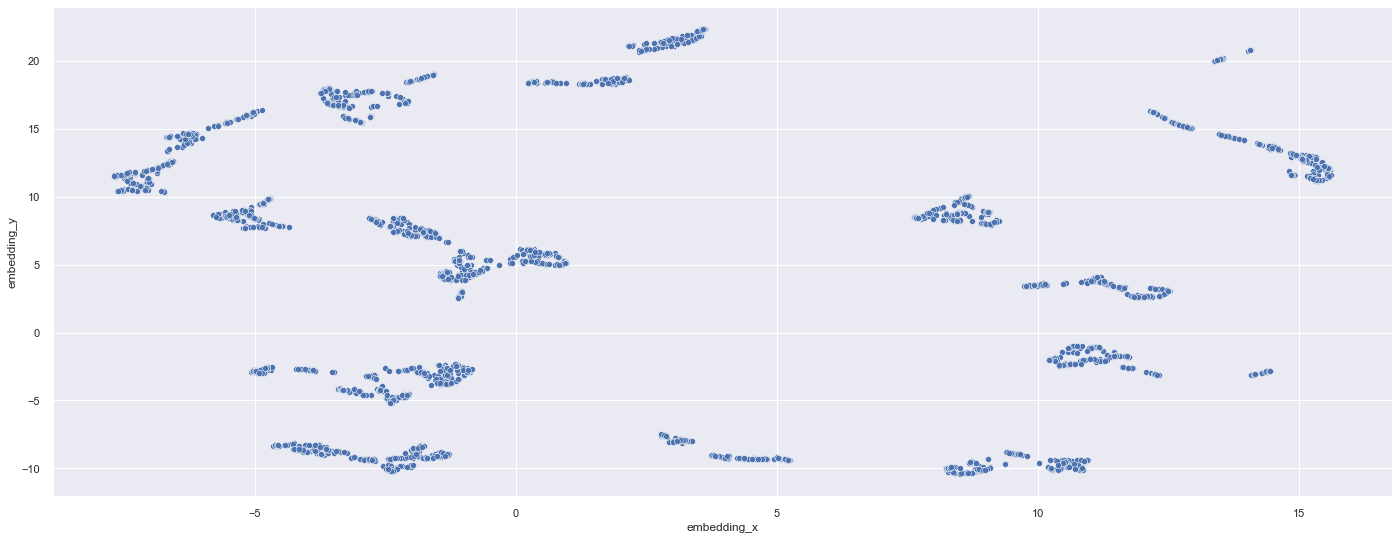

In [209]:
# reducer dimensionality
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(df_leaf)

# embedding
df_pca['embedding_x'] = embedding[:,0]
df_pca['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y',  
                data=df_pca)

Ou seja, a árvore criou espaço bem distintos e separados, onde agora os algoritmos serão rodados, não mais em cima dos espaços anteriores. O ponto negativo é que neste tipo de espaço perde-se a explicabilidade do modelo. Em um espaço euclidiano, observa-se as variáveis e tira-se conclusões fáceis dos agrupamentos, coisa que se perde aqui. 

# 5.0 Data Preparation

In [210]:
df5 = df4.copy() 

In [211]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,5391.21,372.0,297.0,1733.0,297.0,18.15,17849.666667,35.500000,17.000000,40.0,50.970588,0.617647
1,13047,3232.59,56.0,171.0,1390.0,171.0,18.90,13046.923077,27.250000,0.028302,35.0,154.444444,11.666667
2,12583,6705.38,2.0,232.0,5028.0,232.0,28.90,12582.941176,23.187500,0.040323,50.0,335.200000,7.600000
3,13748,948.25,95.0,28.0,439.0,28.0,33.87,13747.750000,92.666667,0.017921,0.0,87.800000,4.800000
4,15100,876.00,333.0,3.0,80.0,3.0,292.00,15099.833333,8.600000,0.073171,22.0,26.666667,0.333333


In [212]:
df5.columns

Index(['customer_id', 'gross_revenue', 'recency_days', 'qtde_invoices',
       'qtde_itens', 'stock_code', 'avg_ticket', 'next_customer_id',
       'avg_recency_days', 'frequency', 'qtde_returns', 'avg_basket_size',
       'avg_unique_basket_size'],
      dtype='object')

In [213]:
ss = pp.StandardScaler()

df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['qtde_invoices'] = ss.fit_transform(df5[['qtde_invoices']])
df5['qtde_itens'] = ss.fit_transform(df5[['qtde_itens']])
df5['stock_code'] = ss.fit_transform(df5[['stock_code']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])
df5['avg_recency_days'] = ss.fit_transform(df5[['avg_recency_days']])
df5['frequency'] = ss.fit_transform(df5[['frequency']])
df5['qtde_returns'] = ss.fit_transform(df5[['qtde_returns']])
df5['avg_basket_size'] = ss.fit_transform(df5[['avg_basket_size']])
df5['avg_unique_basket_size'] = ss.fit_transform(df5[['avg_unique_basket_size']])   

In [214]:
df5.head()

,customer_id,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,next_customer_id,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,17850,0.266212,3.957548,0.645586,0.026453,0.645586,-0.124207,17849.666667,-0.500863,41.372275,0.018074,-0.652758,-1.091529
1,13047,0.053199,-0.106875,0.178725,-0.033677,0.178725,-0.117931,13046.923077,-0.630795,-0.209556,0.000394,-0.288215,-0.376730
2,12583,0.395894,-0.801428,0.404745,0.604084,0.404745,-0.034258,12582.941176,-0.694777,-0.180104,0.053432,0.348595,-0.639816
3,13748,-0.172220,0.394747,-0.351126,-0.200392,-0.351126,0.007328,13747.750000,0.399475,-0.234989,-0.123361,-0.523006,-0.820958
4,15100,-0.179350,3.455926,-0.443757,-0.263327,-0.443757,2.167196,15099.833333,-0.924521,-0.099624,-0.045572,-0.738382,-1.109922


# 6.0 Feature Selection

In [215]:
df6 = df5.copy()

# 7.0 Hyperparameter Fine-Tuning

In [216]:
X = df6.drop(columns=['customer_id', 'next_customer_id'])

In [217]:
X.head()

,gross_revenue,recency_days,qtde_invoices,qtde_itens,stock_code,avg_ticket,avg_recency_days,frequency,qtde_returns,avg_basket_size,avg_unique_basket_size
0,0.266212,3.957548,0.645586,0.026453,0.645586,-0.124207,-0.500863,41.372275,0.018074,-0.652758,-1.091529
1,0.053199,-0.106875,0.178725,-0.033677,0.178725,-0.117931,-0.630795,-0.209556,0.000394,-0.288215,-0.376730
2,0.395894,-0.801428,0.404745,0.604084,0.404745,-0.034258,-0.694777,-0.180104,0.053432,0.348595,-0.639816
3,-0.172220,0.394747,-0.351126,-0.200392,-0.351126,0.007328,0.399475,-0.234989,-0.123361,-0.523006,-0.820958
4,-0.179350,3.455926,-0.443757,-0.263327,-0.443757,2.167196,-0.924521,-0.099624,-0.045572,-0.738382,-1.109922


In [218]:
clusters = [2,3,4,5,6,7]

## 7.1 K-Means

In [219]:
kmeans_list = []
for k in clusters:
# model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X)

    # model predict
    labels = kmeans_model.predict(X)

    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

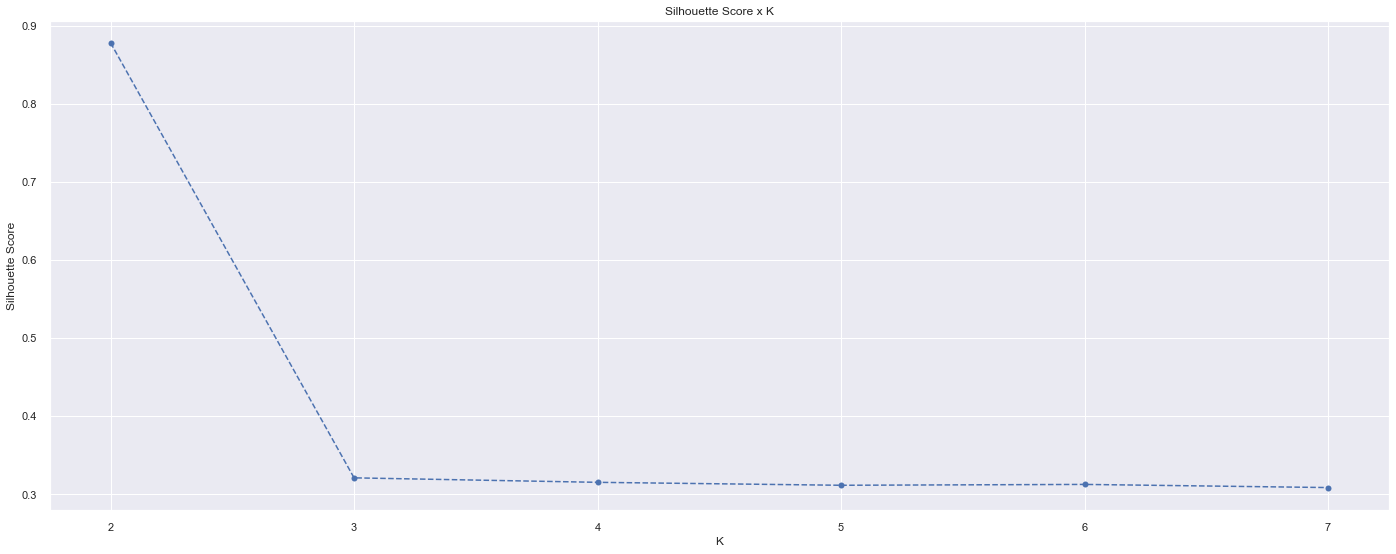

In [220]:
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K')

## 7.2 GMM

In [221]:
from sklearn import mixture as mx

In [222]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    # model training
    gmm_model.fit(X)

    # model predict
    labels = gmm_model.predict(X)
    # model performance
    sil = m.silhouette_score(X, labels, metric='euclidean')
    gmm_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score x K')

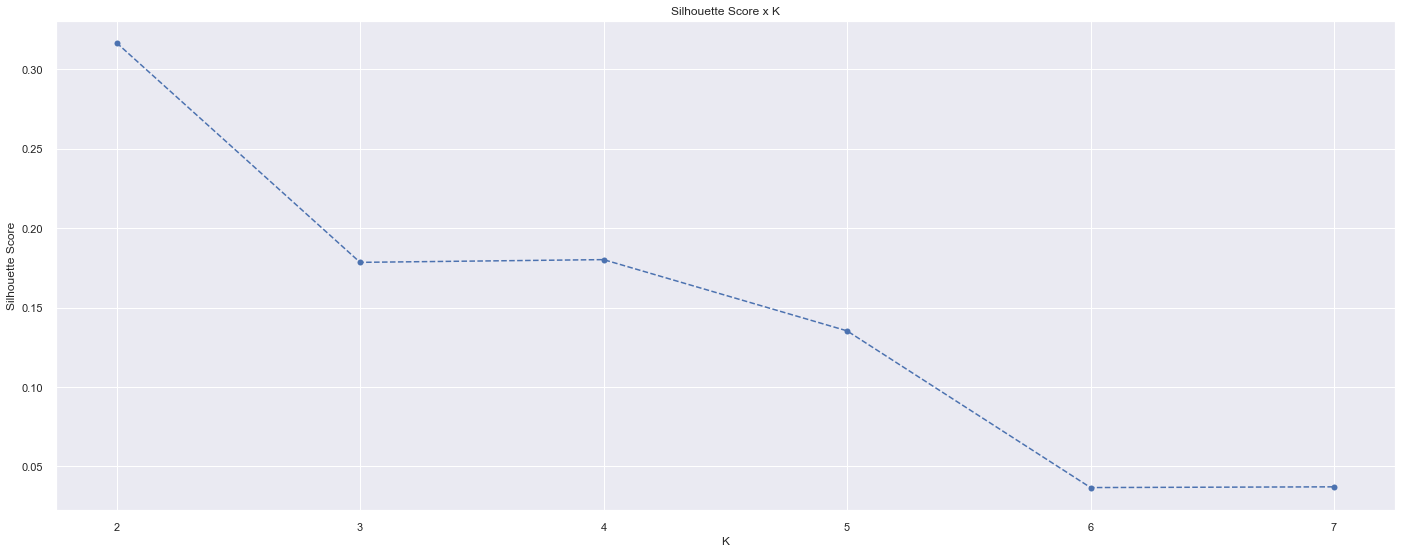

In [223]:
plt.plot(clusters,gmm_list, linestyle='--', marker='o', color='b')
plt.xlabel('K');
plt.ylabel('Silhouette Score');
plt.title('Silhouette Score x K')

AIC - Ajuste dos dados

BIC - Ajuste dos parametros

## 7.3 Hierarchical Clustering

In [224]:
from scipy.cluster import hierarchy as hc

In [225]:
# model definition and training
hc_model = hc.linkage(X, method='ward')

[]

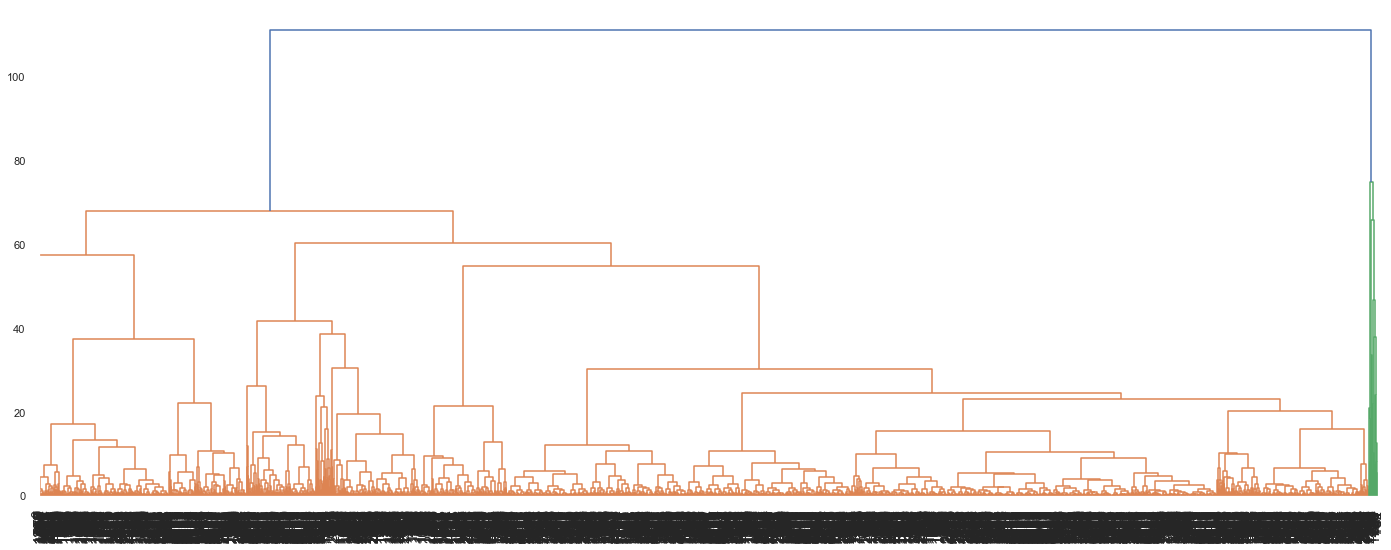

In [226]:
hc.dendrogram(hc_model, leaf_rotation=90, leaf_font_size=15)

plt.plot()

[]

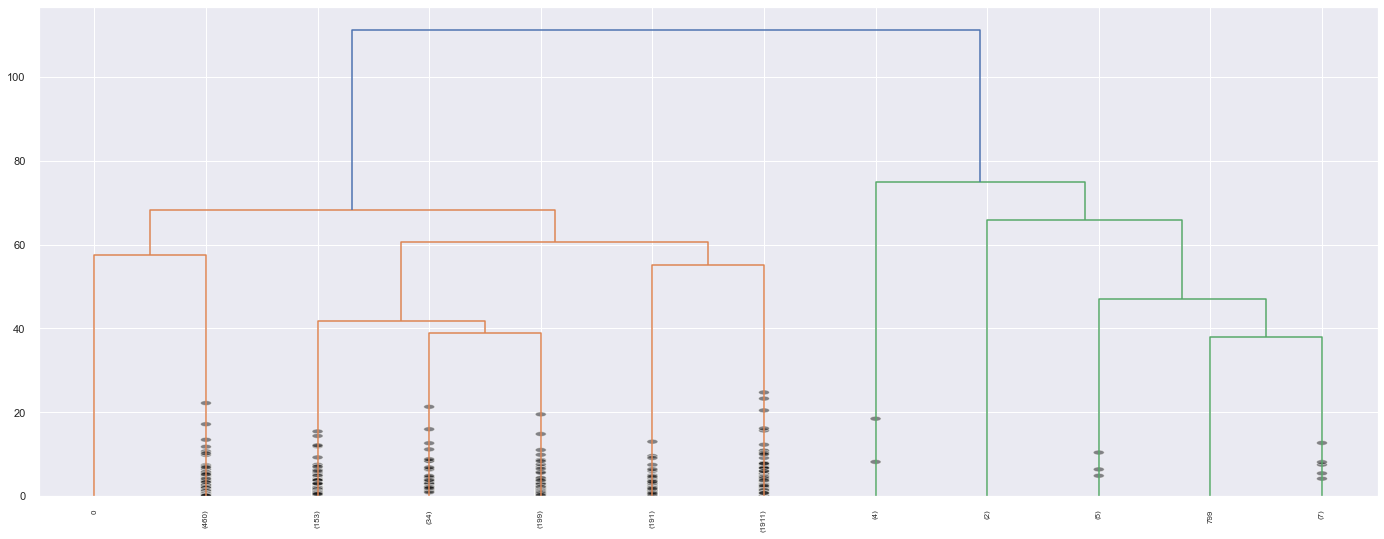

In [227]:
hc.dendrogram(hc_model, truncate_mode='lastp', p=12, leaf_rotation=90, leaf_font_size=8, show_contracted=True)
plt.plot()

### 7.3.1 HClustering Silhouette Score

In [228]:
hc_list = []
for k in clusters:
    # model definition & training
    hc_model = hc.linkage(X,'ward')

    # model predict
    label = hc.fcluster(hc_model, k, criterion='maxclust')

    # metrics
    sil = m.silhouette_score(X, label, metric='euclidean')
    hc_list.append(sil)

In [229]:
hc_list

[0.8828351275017199,
 0.8752284718177373,
 0.30284757274049456,
 0.3035278851196974,
 0.31263178836274896,
 0.30758991515015915]

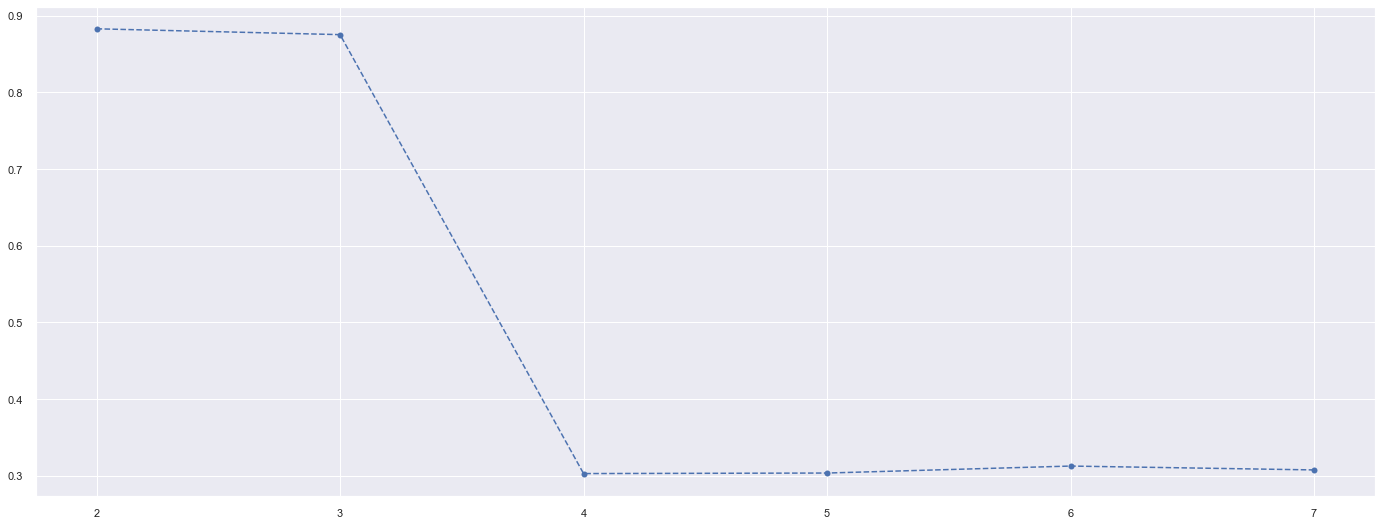

In [230]:
plt.plot(clusters, hc_list, linestyle='--', marker='o', color='b')

## 7.4 DBSCAN

**voltar, o DBSCAN está errado**

In [251]:
eps=0.2
min_samples=2

# model definition

dbscan_model = c.DBSCAN(eps=eps, min_samples=min_samples)

# model training & predict
labels = dbscan_model.fit_predict(X)

sil = m.silhouette_score(X, labels, metric='euclidean')
sil

-0.5125758503023535

In [252]:
unique(labels)

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174], dtype=int64)

In [232]:
from sklearn.neighbors import NearestNeighbors

In [233]:
neighbors = NearestNeighbors(n_neighbors=min_samples).fit(X)
distances, indices = neighbors.kneighbors(X)

In [237]:
dbscan_list = [0.622034, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]

## 7.5 Results

In [253]:
df_results = pd.DataFrame({'Kmeans': kmeans_list,
                           'GMM': gmm_list,
                           'HC': hc_list,
                           'DBSCAN': dbscan_list
                          }).T
df_results.columns = clusters

In [254]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7
Kmeans,0.877990,0.320551,0.314815,0.311042,0.312138,0.308106
GMM,0.316655,0.178457,0.180184,0.135346,0.036708,0.037166
HC,0.882835,0.875228,0.302848,0.303528,0.312632,0.307590
DBSCAN,0.622034,0.000000,0.000000,0.000000,0.000000,0.000000


## 7.1 Within-Cluster Sum of Squares (WSS)

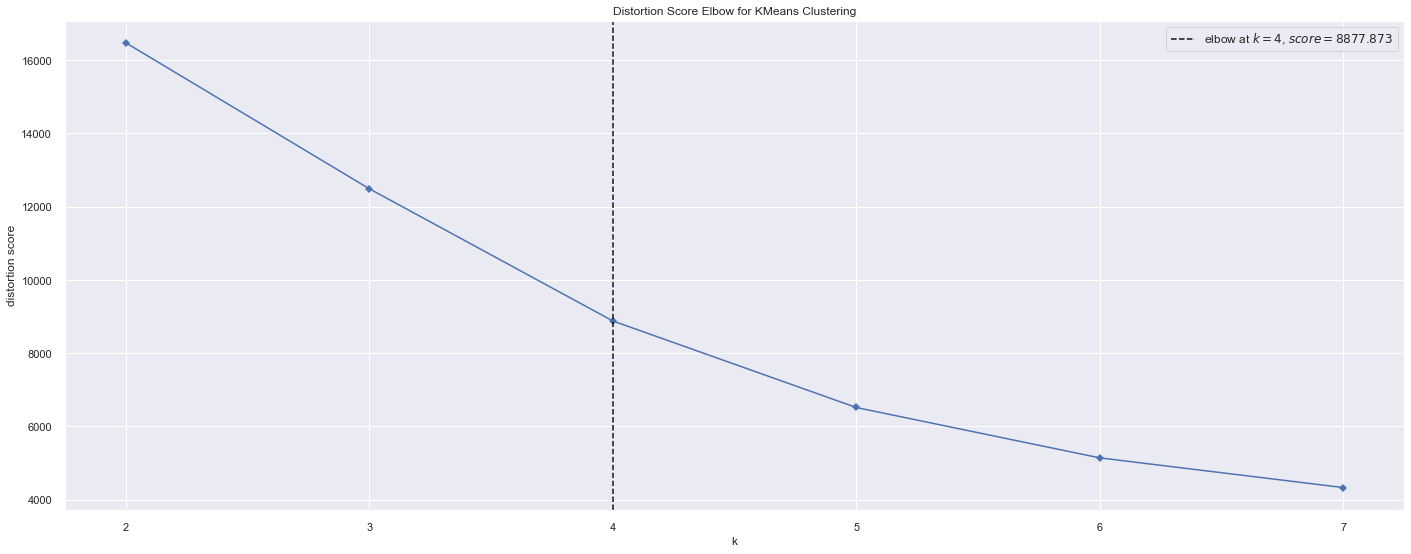

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [66]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show()

## 7.2 Silhouette Score (SS)

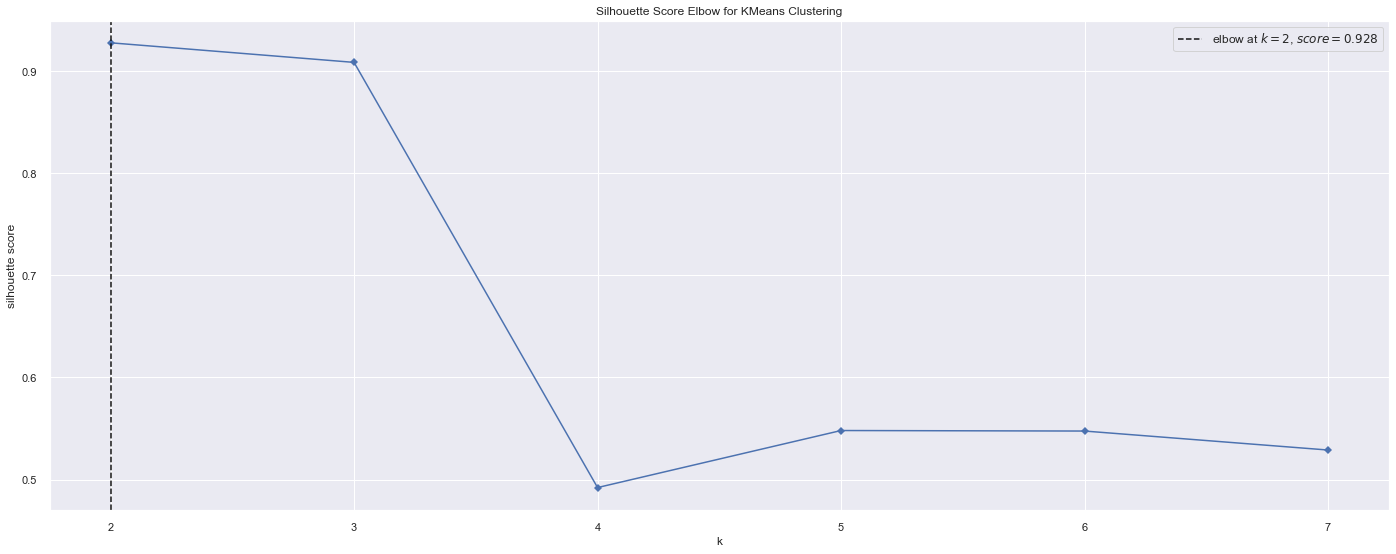

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [67]:
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric='silhouette', timings=False)
kmeans.fit(X)
kmeans.show()

Então, o WSS indicou um total de 3 clusters, enquanto a SS indicou 2 clusters. A escolha é preferível ser a partir da SS, já que considera a distância intra cluster e entre clusters. Porém, se observar os valores de score para a SS, usar 2 ou 3 não influenciará muito negativamente, já que os valores de score não são tão diferentes. Por isso, será optado por utilizar k = 3 a princípio.

## 7.3 Silhouette Analysis

For K = 2 -> Silhouette Score: 0.8828351275017199
For K = 3 -> Silhouette Score: 0.8752284718177373
For K = 4 -> Silhouette Score: 0.30284757274049456
For K = 5 -> Silhouette Score: 0.3035278851196974
For K = 6 -> Silhouette Score: 0.31263178836274896
For K = 7 -> Silhouette Score: 0.30758991515015915


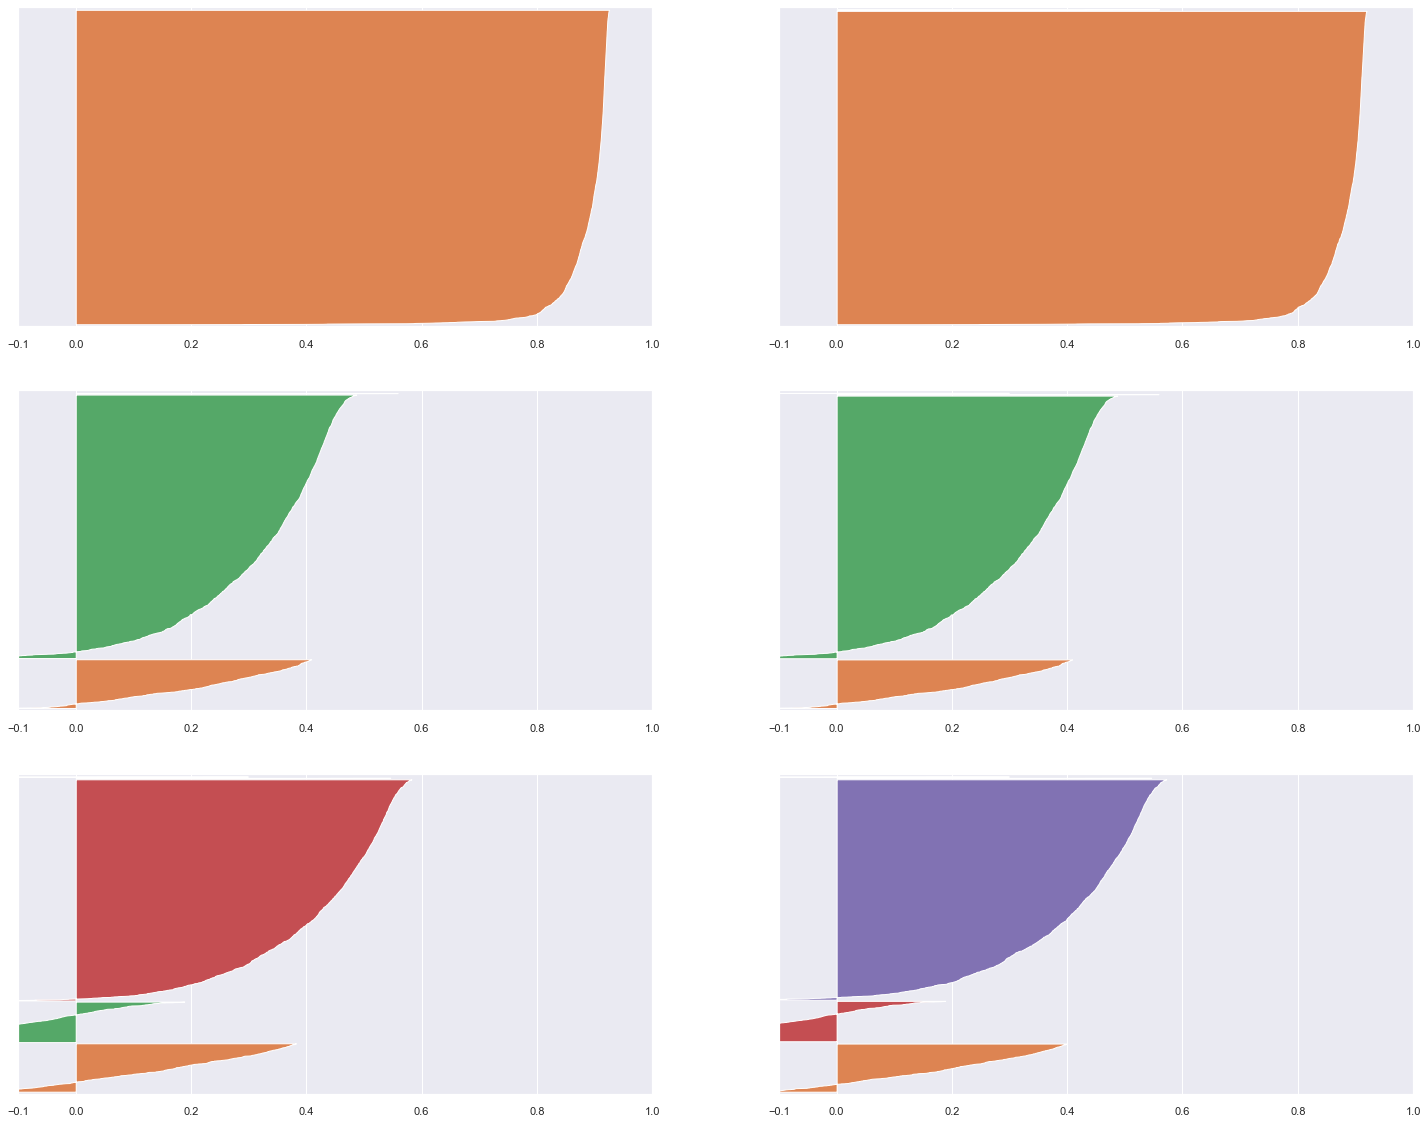

In [249]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q, mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0, len(X) + (k+1)*10])
    
    # model definition & training
    hc_model = hc.linkage(X,'ward')
  
    # model predict
    labels = hc.fcluster(hc_model, k, criterion='maxclust')

    # performance
    ss = m.silhouette_score(X, labels, metric='euclidean')
    print('For K = {} -> Silhouette Score: {}'.format(k,ss))
    
    samples_silhoutte_values = m.silhouette_samples(X, labels)
    
    y_lower = 10
    for i in range(k):

        

        # select clusters
        ith_samples_silhouette_values = samples_silhoutte_values[labels==i] 
        
        # sort values
        ith_samples_silhouette_values.sort()
        
        # size clusters
        size_cluster_i = ith_samples_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        cmap = cm.get_cmap('Spectral')
        color = cmap(i/k)
        
        ax[q-1,mod].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_samples_silhouette_values)
        y_lower = y_upper + 10
    
    ax[q-1, mod].set_yticks([])
    ax[q-1, mod].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

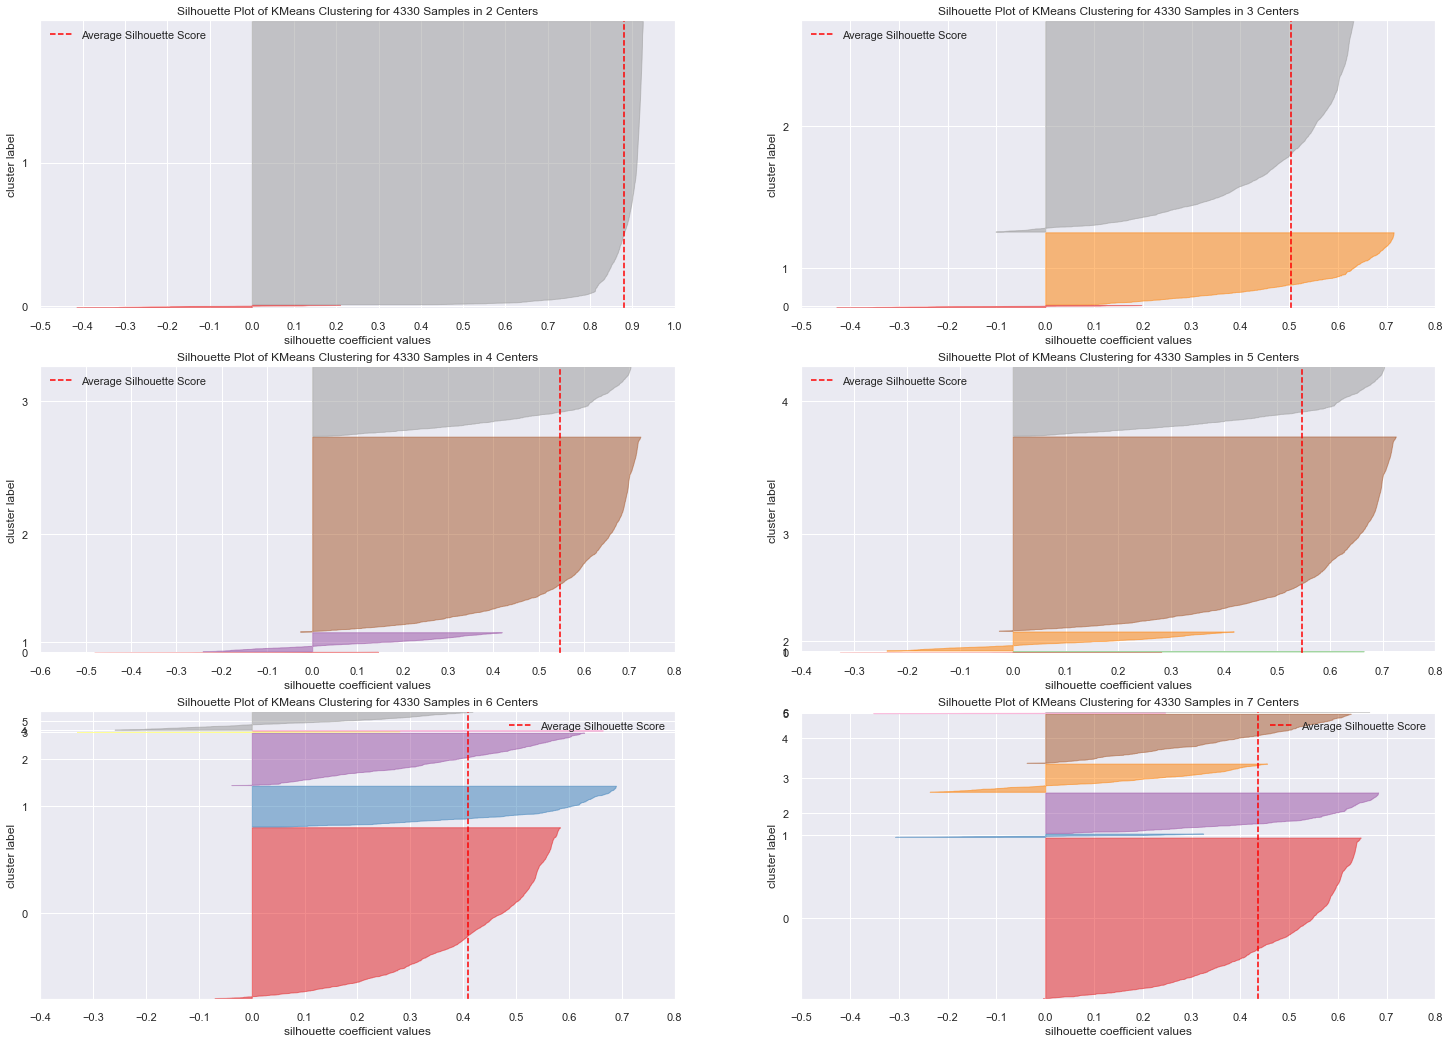

In [68]:
fig,ax = plt.subplots(3,2,figsize=(25,18))

for k in clusters:
    km = c.KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)
    visualizer.finalize()

A princípio, existe um cluster muito maior que os outros que engloba a maior parte dos dados. As métricas não funcionarão bem.

# 8.0 Model Training

## 8.1 K-Means

In [69]:
# model definition
k = 6
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model training
kmeans.fit(X)

# clustering
labels = kmeans.labels_

### 8.1.1 Cluster Validation

In [70]:
print(  f'WSS Value: {kmeans.inertia_}')
print(f'Silhouette Score: {m.silhouette_score(X, labels, metric="euclidean")}')

WSS Value: 6055.382205098947
Silhouette Score: 0.4096373819884112


# 9.0 Cluster Analysis

In [71]:
df9 = df6.copy()
df9['cluster'] = labels

## 9.1 Visualization Inspectionb

In [72]:
 #fig = px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')
 #fig.show()

## 9.2 Visualization Silhouette Visualizer

C:\Users\t.mesha09\Anaconda3\envs\pa005-programa_de_fidelidade\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


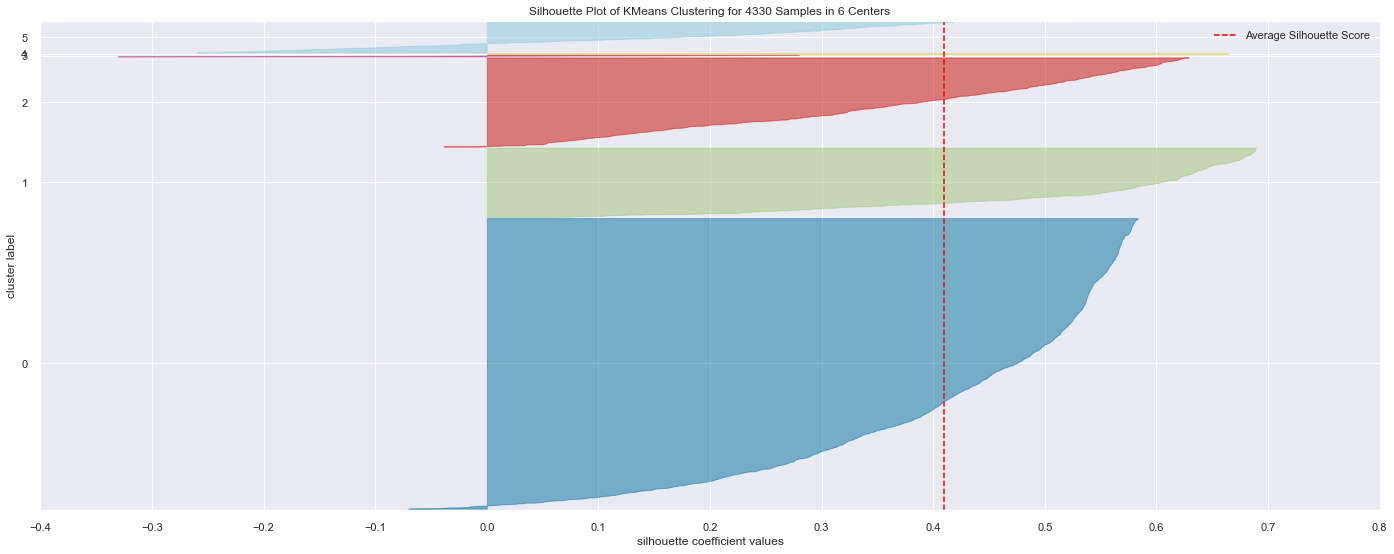

In [73]:
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

In [77]:
#df_viz = df9.drop(columns='customer_id', axis=1)
#sns.pairplot(df_viz, hue='cluster')

## 9.3 UMAP

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

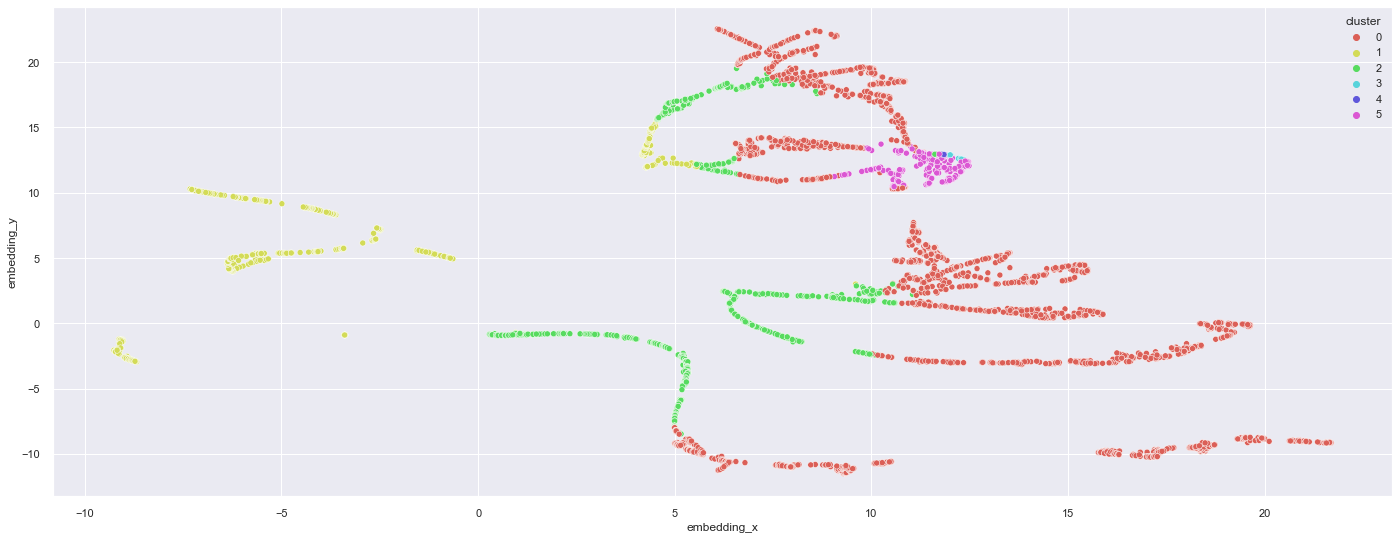

In [75]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_viz['embedding_x'] = embedding[:,0]
df_viz['embedding_y'] = embedding[:,1]

#plot UMAP
sns.scatterplot(x='embedding_x', y='embedding_y', 
                hue='cluster', 
                palette=sns.color_palette('hls', n_colors=len(df_viz['cluster'].unique())), 
                data=df_viz)

## 9.4 Cluster Profile

In [76]:
# number of customer
df_cluster = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100*(df_cluster['customer_id']/df_cluster['customer_id'].sum() )

# average gross revenue
df_avg_gross_revenue = df9[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_gross_revenue, how='inner', on='cluster')

# average recency days
df_avg_recency_days = df9[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_recency_days, how='inner', on='cluster')

# average invoice_no
df_avg_invoice_no = df9[['invoice_no', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster,df_avg_invoice_no, how='inner', on='cluster')

# average ticket
df_ticket = df9[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_ticket, how='inner', on='cluster')

df_cluster

,cluster,customer_id,perc_customer,gross_revenue,recency_days,invoice_no,avg_ticket
0,0,4071,93.115279,946.696250,96.969295,3.641120,25.359654
1,1,6,0.137237,182181.981667,7.166667,89.000000,253.626345
2,2,28,0.640439,42614.387143,6.178571,57.821429,162.862605
3,3,267,6.107045,8089.028652,20.280899,19.528090,62.783157


Se fosse da forma como está definido, o cluster 1, referente aos insiders, que é o cluster com menor recency e maior gross_revenue, seria formado por apenas 6 pessoas.
Além disso, este grupo de 6 pessoas tem um gasto de $182k em média, o que é muito acima de qualquer um dos outros clusters.
Este mesmo cluster tem um tempo de retorno em compra de 7 dias, o que é muito inferior aos outros, o que é excelente para o negócio. Além de ter um total de 89 compras.

### Cluster 01: (Candidato à Insider)
    - Número de customers: 6 (0.14% dos customers)
    - Recência em média: 7 dias
    - Compras em média: 89 compras
    - Receita em média: $182.182,00
    
### Cluster 02:

    - Número de customers: 31 (0.71% dos customers)
    - Recência em média: 14 dias
    - Compras em média: 53 compras
    - Receita em média: $40.543,52
    
### Cluster 03:

    - Número de customers: 4.335 (99% dos customers)
    - Recência em média: 92 dias
    - Compras em média: 5 compras
    - Receita em média: $1.372,57

# 10.0 Deploy to Production